In [218]:
import math
import numpy as np  
import matplotlib.pyplot as plt  
%matplotlib inline

In [219]:
def f(x):
    return 3*x**2 - 4*x + 5

In [220]:
f(3.0)

20.0

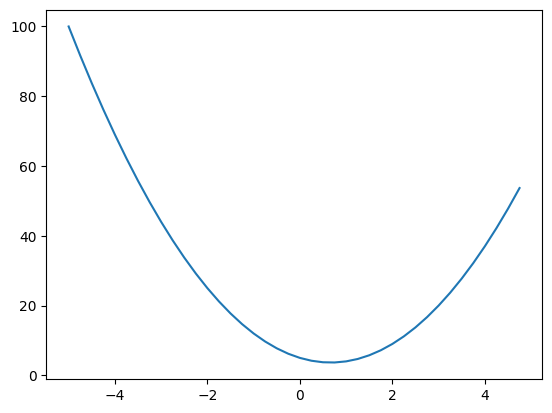

In [221]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [222]:
h = 0.0000001
x = 3.0
(f(x+h)-f(x))/h

14.000000305713911

In [223]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [224]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c 

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [225]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data=data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label= label

    def __repr__(self):
        return f"Vlue(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data , (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

    

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Vlue(data=-8.0)

In [226]:
a = Value(2.0)
a + 1
a * 2
3 * a
a.exp()

Vlue(data=7.38905609893065)

In [227]:
b = Value(4.0)
a / b

Vlue(data=0.5)

In [228]:
a - b

Vlue(data=-2.0)

In [229]:
d._prev

{Vlue(data=-6.0), Vlue(data=10.0)}

In [230]:
d._op

'+'

In [231]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)

    # 1) create nodes (and op nodes)
    for n in nodes:
        uid = str(id(n))
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad),
            shape="record",
        )
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    # 2) create edges between nodes via op nodes
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


## Topolgical sort

In [232]:
# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)

In [233]:
L.grad = 1

## L = d * f
## dL/dd = f

In [234]:
d.grad = -2
f.grad = 4

## dL/dc
### dL/dc = (dL/dd) * (dd/dc) 

In [235]:
c.grad = -2.0
e.grad = -2.0

## dL/da ?
### dL/de = -2
### dL/da = (dL/de)*(de/da)
### e = a * b 
### de/da = b
### dL/da = -2 * -3 = 6

In [236]:
a.grad = 6
b.grad = -4

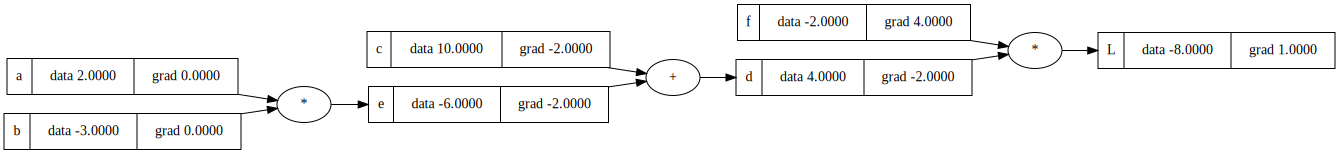

In [237]:
draw_dot(L)

In [238]:
def lol():

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

6.000000000021544


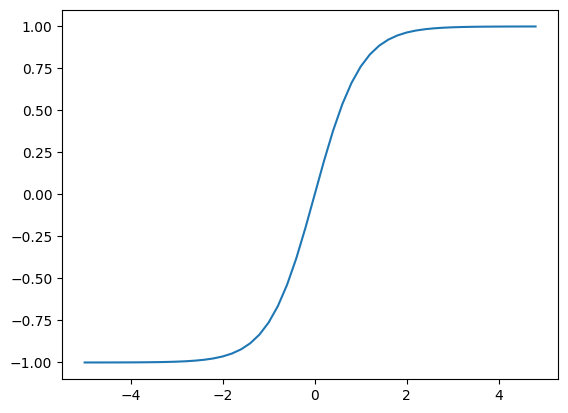

In [239]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));

In [240]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 +b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

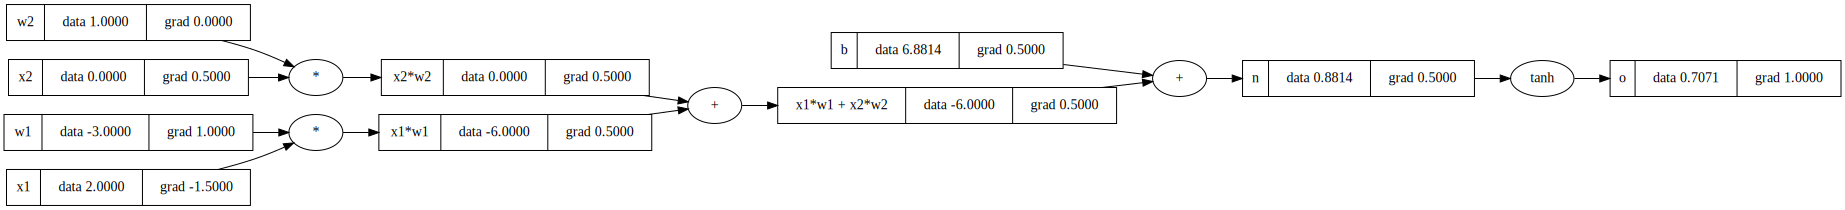

In [241]:
draw_dot(o)

In [242]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 +b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()

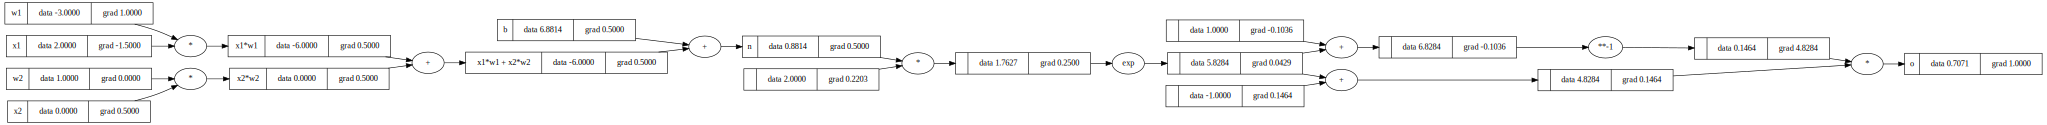

In [243]:
draw_dot(o)

In [244]:
o.grad = 1

## do/dn ?
### do/dn = 1-tanh(n) ** 2

In [245]:
1-o.data**2

0.4999999999999998

In [246]:
o.backward()

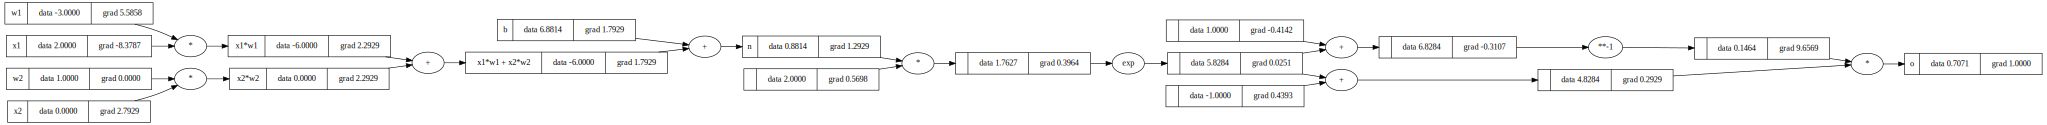

In [247]:
draw_dot(o)

## Issue

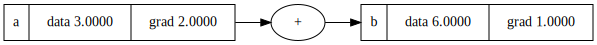

In [248]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

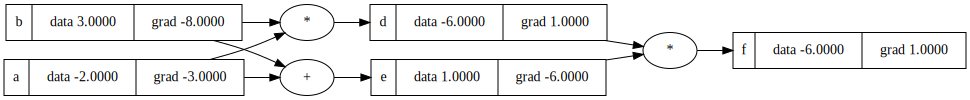

In [249]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()

draw_dot(f)

## pytorch

In [250]:
import torch

In [251]:
x1 = torch.Tensor([2.0]).double()                        ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                        ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                       ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                        ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()          ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('_________')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
_________
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w2 0.0


In [252]:
import random

In [253]:
class Neuron:

    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w +[self.b]

class Layer:

    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x       
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [254]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Vlue(data=0.9636180742558755)

In [255]:
n.parameters()

[Vlue(data=0.3508830411364745),
 Vlue(data=-0.6903246407822823),
 Vlue(data=-0.02912325852197939),
 Vlue(data=-0.6884031742707659),
 Vlue(data=0.42182536911124546),
 Vlue(data=0.161250155519286),
 Vlue(data=0.7558865853785945),
 Vlue(data=-0.8828398343864998),
 Vlue(data=0.263851516627178),
 Vlue(data=-0.4144301562402566),
 Vlue(data=0.8859868908686825),
 Vlue(data=0.3866231997025644),
 Vlue(data=0.8777105743320373),
 Vlue(data=-0.4220406292361343),
 Vlue(data=0.7518480435559043),
 Vlue(data=0.8609015136784703),
 Vlue(data=-0.2768815197311505),
 Vlue(data=0.3831273662290773),
 Vlue(data=-0.903822240791119),
 Vlue(data=-0.03772648076330354),
 Vlue(data=0.7849237271326679),
 Vlue(data=0.04068661691782505),
 Vlue(data=-0.6179161152043426),
 Vlue(data=-0.10291304658734823),
 Vlue(data=0.804545077777254),
 Vlue(data=0.8449226556847749),
 Vlue(data=-0.8442711836961654),
 Vlue(data=0.5831606122756443),
 Vlue(data=-0.6435244194291863),
 Vlue(data=-0.1567582127977314),
 Vlue(data=-0.63072217411

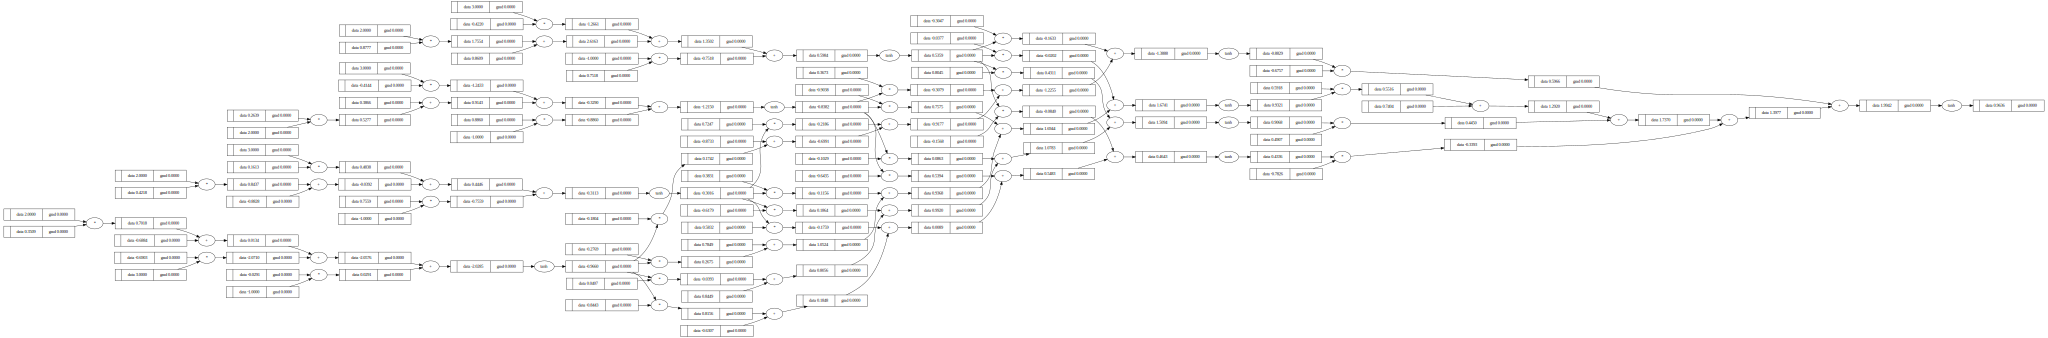

In [256]:
draw_dot(n(x))

## example

In [257]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0,-1.0, -1.0, 1.0]  # desired targets

In [258]:
ypred = [n(x) for x in xs]
ypred

[Vlue(data=0.9636180742558755),
 Vlue(data=0.973949650516696),
 Vlue(data=0.966121661622424),
 Vlue(data=0.9851340369318022)]

In [259]:
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
loss

Vlue(data=7.763656252454704)

In [260]:
loss.backward()

In [261]:
n.layers[0].neurons[0].w[0].grad

0.02095951958140272

In [262]:
n.layers[0].neurons[0].w[0].data

0.3508830411364745

In [263]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [264]:
n.layers[0].neurons[0].w[0].data

0.35067344594066047

In [265]:
ypred = [n(x) for x in xs]
ypred

[Vlue(data=0.9625331379990799),
 Vlue(data=0.9728183869154342),
 Vlue(data=0.9644090583588576),
 Vlue(data=0.9846997383944374)]

In [266]:
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
loss

Vlue(data=7.752553200067344)

In [267]:
loss.backward()

In [268]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [269]:
ypred = [n(x) for x in xs]
ypred

[Vlue(data=0.9602217161781936),
 Vlue(data=0.9703500081936596),
 Vlue(data=0.960627352535795),
 Vlue(data=0.9837744082578485)]

In [270]:
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))
loss

Vlue(data=7.728184351991465)

## very important : when we back propagete we need to set gradients to be zero otherwise they will acumilate

In [ ]:
for k in range(1000):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0                # very very common mistake
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)

0 0.03790930571866766
1 0.03741380919187327
2 0.03693114239445254
3 0.036460811096022436
4 0.036002346152082726
5 0.03555530193452104
6 0.03511925487820814
7 0.03469380213381529
8 0.03427856031793133
9 0.03387316435239998
10 0.033477266385554455
11 0.03309053478870176
12 0.0327126532218203
13 0.03234331976297541
14 0.03198224609645435
15 0.031629156755060284
16 0.03128378841240625
17 0.03094588922140951
18 0.030615218195513126
19 0.030291544629454794
20 0.029974647556671875
21 0.029664315240671014
22 0.029360344697913397
23 0.0290625412499631
24 0.028770718102830946
25 0.028484695951607554
26 0.028204302608633946
27 0.027929372653592008
28 0.027659747104024916
29 0.027395273104910838
30 0.027135803636017874
31 0.026881197235865503
32 0.026631317741204738
33 0.02638603404100819
34 0.02614521984403933
35 0.025908753459133224
36 0.02567651758738668
37 0.02544839912551234
38 0.025224288979663494
39 0.025004081889085164
40 0.02478767625899271
41 0.024574974002119828
42 0.024365880388415185


In [274]:
ypred

[Vlue(data=0.9732066469148564),
 Vlue(data=-0.9772234061921582),
 Vlue(data=-0.9710135974709073),
 Vlue(data=0.978165244658697)]